In [60]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
from DataGenerator import generateOneClusterData
from Settings import (DEFAULT_NUMBER_OF_FEATURES,
                        DEFAULT_NUMBER_OF_RECORDS_PER_CLASS,
                        DEFAULT_FEATURE_MEAN_RANGE,
                        DEFAULT_RANDOM_NUMBER_SEED)

data = generateOneClusterData(DEFAULT_NUMBER_OF_FEATURES,
                            DEFAULT_NUMBER_OF_RECORDS_PER_CLASS,
                            DEFAULT_FEATURE_MEAN_RANGE, 
                            DEFAULT_RANDOM_NUMBER_SEED)


rcParams['figure.figsize'] = (8.0, 8.0)
from gap_statistic import OptimalK
optimalK = OptimalK(parallel_backend='joblib')

cluster_point_size = 3

perplexity_range = [30]
cluster_arr = range(1,5)

data_uniform_pertubed = np.delete(data,20,axis=0)

In [61]:
def tsne(data, n_comp, perplexity, plot = False, ret=True):
        tsne_obj = TSNE(n_components=n_comp, perplexity=perplexity)
        X_embedded = tsne_obj.fit_transform(data)
        
        if plot:
            plt.scatter(X_embedded[:,0], X_embedded[:,1], s=cluster_point_size)
            optK = optimalK(X_embedded, cluster_array=cluster_arr)
            plt.title("Perplexity: {}, Optimal K: {}, Kullback-Leibler Divergence: {}".format(perplexity, optK, tsne_obj.kl_divergence_))
            plt.show()
        
        if ret:
            return tsne_obj.kl_divergence_
    
def generate_dataset(seed=0):
    return generateOneClusterData(DEFAULT_NUMBER_OF_FEATURES,
                            DEFAULT_NUMBER_OF_RECORDS_PER_CLASS,
                            DEFAULT_FEATURE_MEAN_RANGE, 
                            seed)

## t-SNE (Gaussian)

In [51]:
nr_datasets = 10
nr_pertubations = 10
kls = np.zeros(nr_datasets)
perplexity = 30 

nr_components = 3

kl_normal = np.zeros(nr_components) 


mean_kl_removal_diff = np.zeros([nr_components, nr_datasets])
std_kl_removal_diff = np.zeros([nr_components, nr_datasets])

mean_kl_scaling_diff = np.zeros([nr_components, nr_datasets])
std_kl_scaling_diff = np.zeros([nr_components, nr_datasets])


for iNrComponents in range(nr_components):
    
    print("======================== # Components {} of {} ========================".format(iNrComponents+1, nr_components))
    
    for iDataset in range(nr_datasets):
        print("======================== Dataset {} of {} ========================".format(iDataset+1, nr_datasets))
        data = generate_dataset(iDataset)

        kls = np.zeros(nr_pertubations) 
        removal_kls = np.zeros(nr_pertubations)
        scaling_kls = np.zeros(nr_pertubations)

        kl_normal[iNrComponents] = tsne(data, iNrComponents+1, perplexity)

        # Random data point removal pertubation
        for j in range(nr_pertubations):
            print("Removal pertubation {} of {}".format(j+1,nr_pertubations))
            data_removal = np.delete(data,random.randint(1, len(data)-1),axis=0)
            
            removal_kls[j] = kl_normal[iNrComponents] - tsne(data_removal, iNrComponents+1, perplexity)

        # Random data point scaling pertubation
        for j in range(nr_pertubations):
            print("Scaling pertubation {} of {}".format(j+1,nr_pertubations))
            data_rescaled = np.copy(data)

            # Scale 20 %
            random_dp_idx = random.randint(1, len(data)-1)
            random_dp = data_rescaled[random_dp_idx, :] 
            data_rescaled[random_dp_idx, :] = random_dp*1.20
            scaling_kls[j] = kl_normal[iNrComponents] - tsne(data_rescaled, iNrComponents+1, perplexity)


        mean_kl_removal_diff[iNrComponents, iDataset] = np.mean(removal_kls)
        std_kl_removal_diff[iNrComponents, iDataset] =  np.std(removal_kls)
        
        mean_kl_scaling_diff[iNrComponents, iDataset] = np.mean(scaling_kls)
        std_kl_scaling_diff[iNrComponents, iDataset] =  np.std(scaling_kls)
            
            
        print("No pertubation - Avg KL Div: {}, KL Div STD: {}".format(np.mean(kls), np.std(kls)))
        print("Random Removal - Avg KL Div: {}, KL Div STD: {}".format(np.mean(removal_kls), np.std(removal_kls)))
        print("Random Scaling - Avg KL Div: {}, KL Div STD: {}".format(np.mean(scaling_kls), np.std(scaling_kls)))
        print("\n")


======================== # Components 1 of 3 ========================
======================== Dataset 1 of 10 ========================
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10


KeyboardInterrupt: 

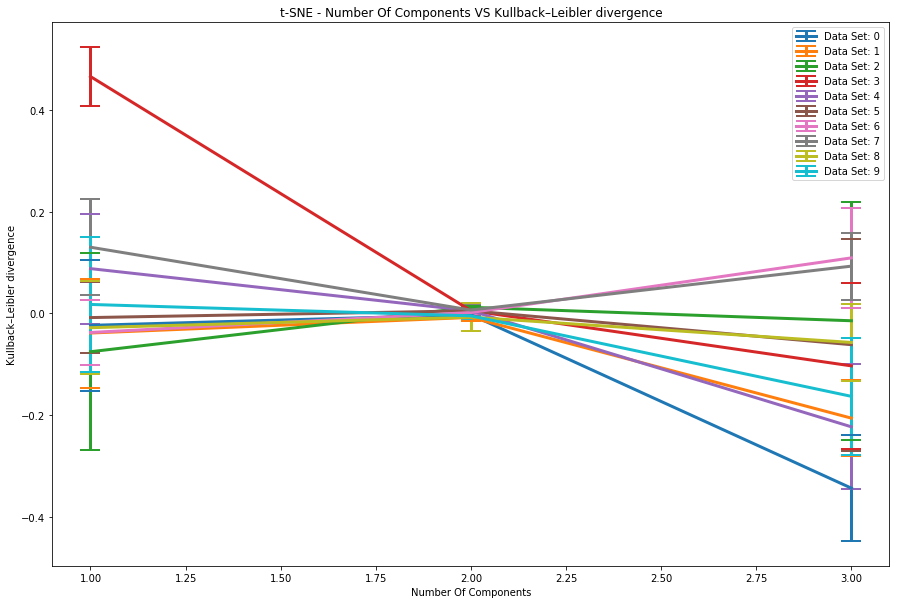

In [46]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(range(1, nr_components+1), mean_kl_removal_diff[:,i], yerr=std_kl_removal_diff[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Number Of Components VS Kullback–Leibler divergence")
plt.xlabel("Number Of Components")
plt.ylabel("Kullback–Leibler divergence")
plt.legend()

plt.show()

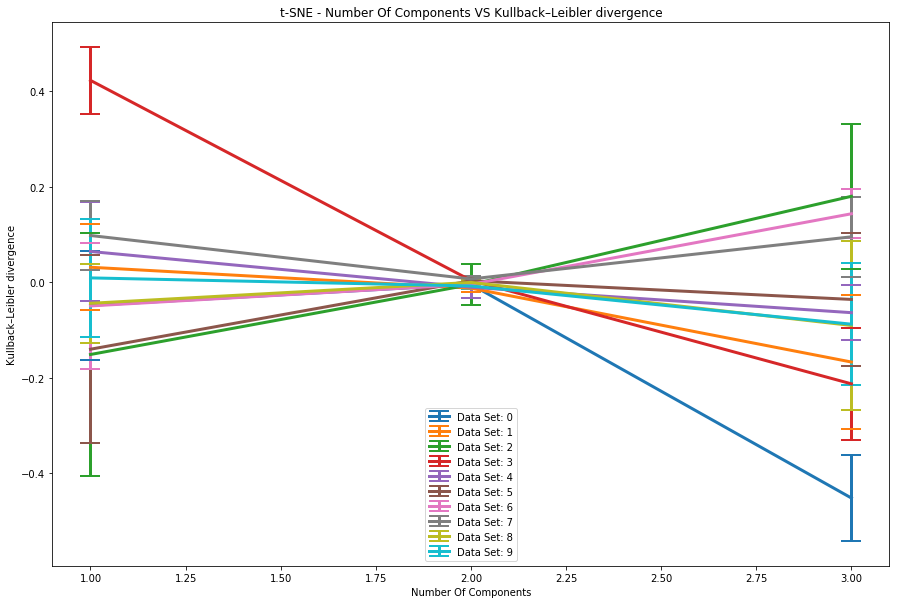

In [47]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(range(1, nr_components+1), mean_kl_scaling_diff[:,i], yerr=std_kl_scaling_diff[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Number Of Components VS Kullback–Leibler divergence")
plt.xlabel("Number Of Components")
plt.ylabel("Kullback–Leibler divergence")
plt.legend()

plt.show()

## Varying perplexity

It seems like using two components produces the most 'stable' reduction of dimensionality.

In [48]:
nr_datasets = 10
nr_pertubations = 10
nr_components = 2

perplexities = [5, 20, 30, 50]

nr_perp = len(perplexities)

perp_normal = np.zeros(nr_perp) 

mean_perp_removal_diff = np.zeros([nr_perp, nr_datasets])
std_perp_removal_diff = np.zeros([nr_perp, nr_datasets])

mean_perp_scaling_diff = np.zeros([nr_perp, nr_datasets])
std_perp_scaling_diff = np.zeros([nr_perp, nr_datasets])



for i_p,prep in enumerate(perplexities):
    print("================================================================")
    print("                         Perplexity {}                          ".format(prep))
    print("================================================================")
    
    
    perplexity = prep

    mean_kl_removal_diff = np.zeros([nr_components, nr_datasets])
    std_kl_removal_diff = np.zeros([nr_components, nr_datasets])

    mean_kl_scaling_diff = np.zeros([nr_components, nr_datasets])
    std_kl_scaling_diff = np.zeros([nr_components, nr_datasets])


    for iDataset in range(nr_datasets):
        print("======================== Dataset {} of {} ========================".format(iDataset+1, nr_datasets))
        data = generate_dataset(iDataset)

        kls = np.zeros(nr_pertubations) 
        removal_kls = np.zeros(nr_pertubations)
        scaling_kls = np.zeros(nr_pertubations)

        perp_normal[i_p] = tsne(data, nr_components, perplexity)

        # Random data point removal pertubation
        for j in range(nr_pertubations):
            print("Removal pertubation {} of {}".format(j+1,nr_pertubations))
            data_removal = np.delete(data,random.randint(1, len(data)-1),axis=0)

            removal_kls[j] = perp_normal[i_p] - tsne(data_removal, nr_components, perplexity)

        # Random data point scaling pertubation
        for j in range(nr_pertubations):
            print("Scaling pertubation {} of {}".format(j+1, nr_pertubations))
            data_rescaled = np.copy(data)

            # Scale 20 %
            random_dp_idx = random.randint(1, len(data)-1)
            random_dp = data_rescaled[random_dp_idx, :] 
            data_rescaled[random_dp_idx, :] = random_dp*1.20
            scaling_kls[j] = perp_normal[i_p] - tsne(data_rescaled, nr_components, perplexity)


        mean_perp_removal_diff[i_p, iDataset] = np.mean(removal_kls)
        std_perp_removal_diff[i_p, iDataset] =  np.std(removal_kls)

        mean_perp_scaling_diff[i_p, iDataset] = np.mean(scaling_kls)
        std_perp_scaling_diff[i_p, iDataset] =  np.std(scaling_kls)


        print("No pertubation - Avg KL Div: {}, KL Div STD: {}".format(np.mean(kls), np.std(kls)))
        print("Random Removal - Avg KL Div: {}, KL Div STD: {}".format(np.mean(removal_kls), np.std(removal_kls)))
        print("Random Scaling - Avg KL Div: {}, KL Div STD: {}".format(np.mean(scaling_kls), np.std(scaling_kls)))
        print("\n")


                         Perplexity 5                          
======================== Dataset 1 of 10 ========================
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
No pertubation - Avg KL Div: 0.0, KL Div STD: 0.0
Random Removal - Avg KL Div: 0.00462489128112793, KL Div STD: 0.023622859442029888
Random Scaling - Avg KL Div: 0.0026667475700378417, KL Div STD: 0.021660056266018832


======================== Dataset 2 of 10 ========================
Removal pertubation 1 

Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
No pertubation - Avg KL Div: 0.0, KL Div STD: 0.0
Random Removal - Avg KL Div: 0.010538744926452636, KL Div STD: 0.019269705322285748
Random Scaling - Avg KL Div: 0.007378280162811279, KL Div STD: 0.022435059902547023


                         Perplexity 20                          
======================== Dataset 1 of 10 ========================
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Sca

Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
No pertubation - Avg KL Div: 0.0, KL Div STD: 0.0
Random Removal - Avg KL Div: -0.011585772037506104, KL Div STD: 0.011935384950569268
Random Scaling - Avg KL Div: -0.00624617338180542, KL Div STD: 0.008366723822200718


                         Perplexity 30                          
======================== Dataset 1 of 10 ========================
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Re

Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
No pertubation - Avg KL Div: 0.0, KL Div STD: 0.0
Random Removal - Avg KL Div: 0.004272294044494629, KL Div STD: 0.0075450976535265555
Random Scaling - Avg KL Div: -0.0014148592948913575, KL Div STD: 0.005173928040843471


======================== Dataset 10 of 10 ========================
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling 

Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
No pertubation - Avg KL Div: 0.0, KL Div STD: 0.0
Random Removal - Avg KL Div: 0.0037726938724517824, KL Div STD: 0.0031210482416246296
Random Scaling - Avg KL Div: 0.0013036668300628663, KL Div STD: 0.0037642980427774054


======================== Dataset 10 of 10 ========================
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal

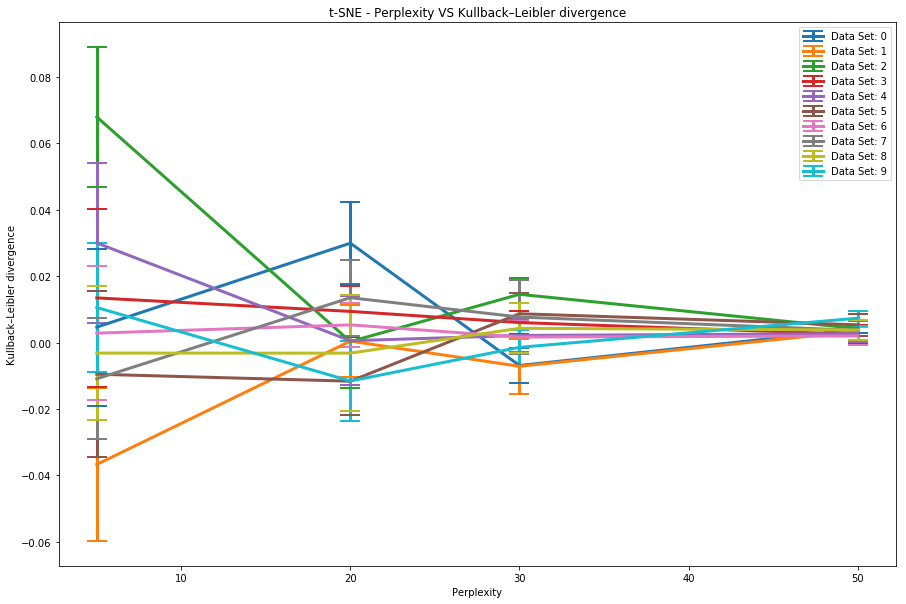

In [49]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(perplexities, mean_perp_removal_diff[:,i], yerr=std_perp_removal_diff[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Perplexity VS Kullback–Leibler divergence")
plt.xlabel("Perplexity")
plt.ylabel("Kullback–Leibler divergence")
plt.legend()

plt.show()

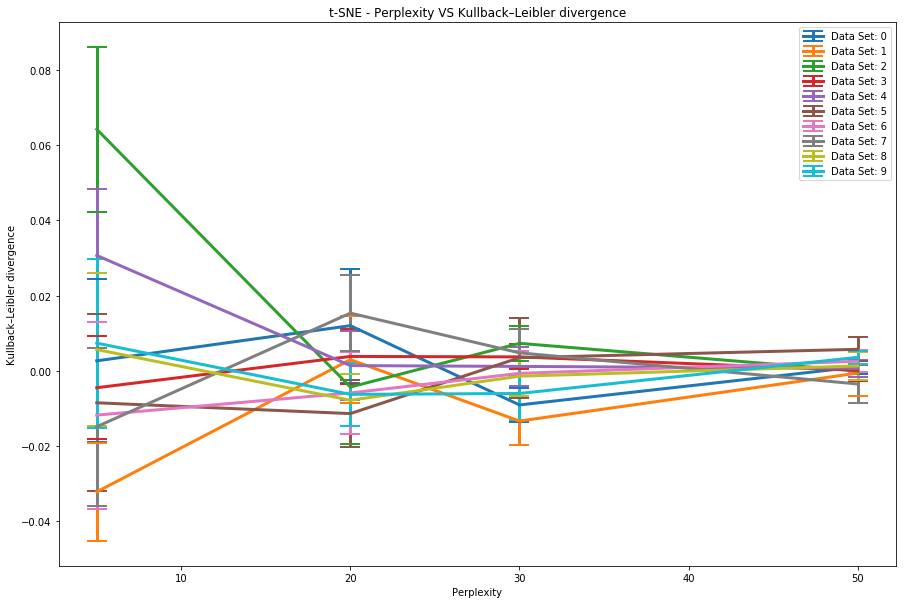

In [50]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(perplexities, mean_perp_scaling_diff[:,i], yerr=std_perp_scaling_diff[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Perplexity VS Kullback–Leibler divergence")
plt.xlabel("Perplexity")
plt.ylabel("Kullback–Leibler divergence")
plt.legend()

plt.show()

1

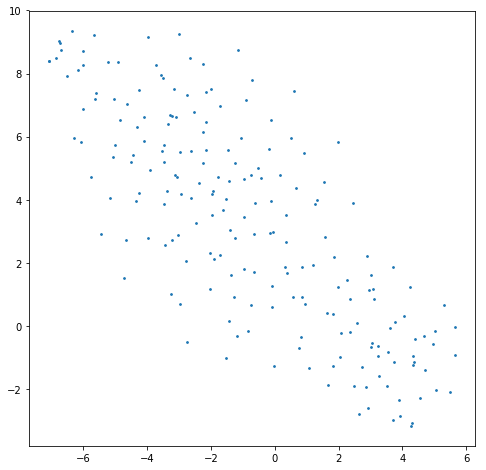

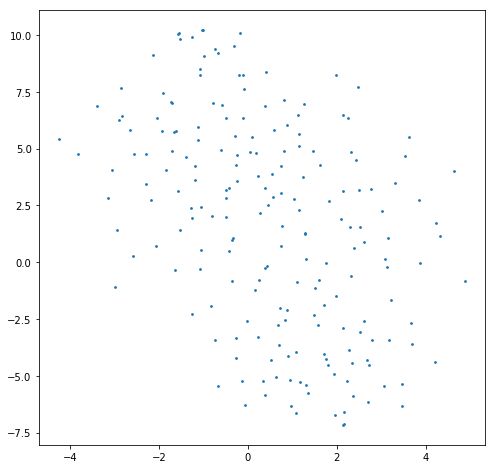

In [75]:
data = generate_dataset(0)
data2 = generate_dataset(22)

from scipy.spatial import procrustes



tsne_obj = TSNE(n_components=2, perplexity=30)
X_embedded = tsne_obj.fit_transform(data)
X_embedded2 = tsne_obj.fit_transform(data)
X_embedded3 = tsne_obj.fit_transform(data2)

plt.scatter(X_embedded[:,0],X_embedded[:,1],  s=cluster_point_size)
plt.show()
plt.scatter(X_embedded2[:,0],X_embedded2[:,1],  s=cluster_point_size)
plt.show()



In [76]:
max(directed_hausdorff(X_embedded, X_embedded2)[0], directed_hausdorff(X_embedded2, X_embedded)[0])

4.4167127165351205

In [94]:
def hd(a,b):
    return max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])

## Comparing Hausdorf Distance for different number of components

In [120]:
nr_datasets = 10
nr_pertubations = 10
nr_components = 3
perplexity = 30

hd_no_pert = np.zeros(nr_components) 

mean_hd_removal_diff = np.zeros([nr_components, nr_datasets])
std_hd_removal_diff = np.zeros([nr_components, nr_datasets])

mean_hd_scaling_diff = np.zeros([nr_components, nr_datasets])
std_hd_scaling_diff = np.zeros([nr_components, nr_datasets])


for iNrComponents, nrComponents in enumerate(range(1,nr_components + 1)):
    print("================================================================")
    print("                         {} Components                          ".format(nrComponents))
    print("================================================================")

    for iDataset in range(nr_datasets):
        print("======================== Dataset {} of {} ========================".format(iDataset+1, nr_datasets))
        data = generate_dataset(iDataset)
        
        
        no_pertubation_data = np.zeros([nr_pertubations, data.shape[0], data.shape[1]])
        for iNoPert in range(nr_pertubations):
            print("No pertubation tsne {} of {}".format(iNoPert+1,nr_pertubations))
            no_pertubation_data[iNoPert,:,:] = tsne(data, nrComponents, perplexity)
            
        # Pairwise comparison
        no_pert = [hd(x,y) for i,x in enumerate(no_pertubation_data) \
                    for j,y in enumerate(no_pertubation_data) if i != j]
        
        # Random data point removal pertubation
        removal_pertubation_data = np.zeros([nr_pertubations, data.shape[0]-1, data.shape[1]])
        for j in range(nr_pertubations):
            print("Removal pertubation {} of {}".format(j+1,nr_pertubations))
            data_removal = np.delete(data,random.randint(1, len(data)-1),axis=0)
            removal_pertubation_data[j,:,:] = tsne(data_removal, nrComponents, perplexity)
            
        removal_pertubed = [hd(x,y) for i,x in enumerate(removal_pertubation_data) \
                    for j,y in enumerate(removal_pertubation_data) if i != j]
        
        
        # Random data point scaling pertubation
        scaling_pertubation_data = np.zeros([nr_pertubations, data.shape[0], data.shape[1]])
        for j in range(nr_pertubations):
            print("Scaling pertubation {} of {}".format(j+1, nr_pertubations))
            data_rescaled = np.copy(data)

            # Scale 20 %
            random_dp_idx = random.randint(1, len(data)-1)
            random_dp = data_rescaled[random_dp_idx, :] 
            data_rescaled[random_dp_idx, :] = random_dp*1.20
            scaling_pertubation_data[j,:,:] = tsne(data_rescaled, nrComponents, perplexity)
        
        scaling_pertubed = [hd(x,y) for i,x in enumerate(scaling_pertubation_data) \
                    for j,y in enumerate(scaling_pertubation_data) if i != j]
        
        mean_hd_removal_diff[iNrComponents,iDataset] = np.mean(removal_pertubed - np.mean(no_pert))
        std_hd_removal_diff[iNrComponents,iDataset] = np.std(removal_pertubed-np.mean(no_pert))
        
        mean_hd_scaling_diff[iNrComponents,iDataset] = np.mean(scaling_pertubed-np.mean(no_pert))
        std_hd_scaling_diff[iNrComponents,iDataset] = np.std(scaling_pertubed-np.mean(no_pert))
        
       

                         1 Components                          
======================== Dataset 1 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
======================== Da

Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
======================== Dataset 10 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scalin

Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
======================== Dataset 9 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scalin

Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
Scaling pertubation 1 of 10
Scaling pertubation 2 of 10
Scaling pertubation 3 of 10
Scaling pertubation 4 of 10
Scaling pertubation 5 of 10
Scaling pertubation 6 of 10
Scaling pertubation 7 of 10
Scaling pertubation 8 of 10
Scaling pertubation 9 of 10
Scaling pertubation 10 of 10
======================== Dataset 8 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal

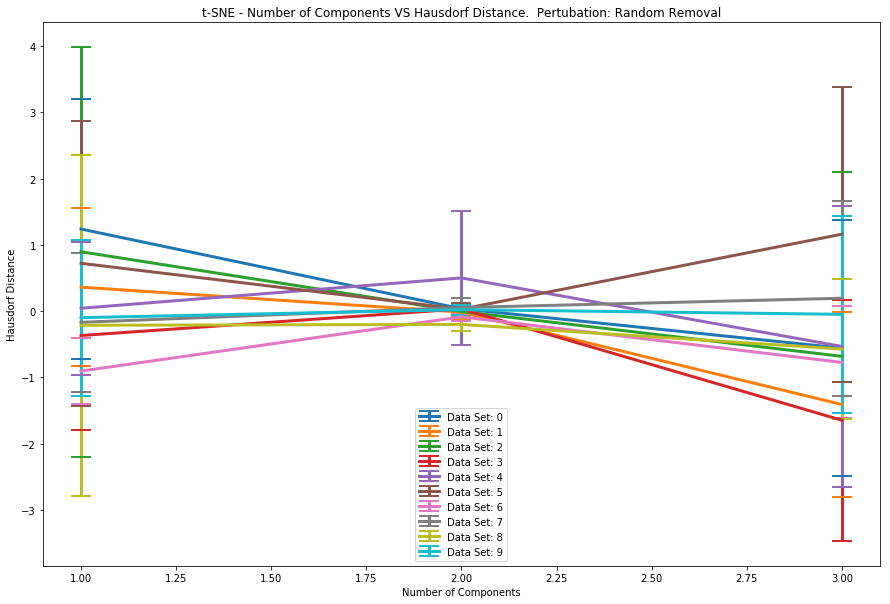

In [132]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(range(1,4), mean_hd_removal_diff[:,i], yerr=std_hd_removal_diff[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Number of Components VS Hausdorf Distance.  Pertubation: Random Removal")
plt.xlabel("Number of Components")
plt.ylabel("Hausdorf Distance")
plt.legend()

plt.show()

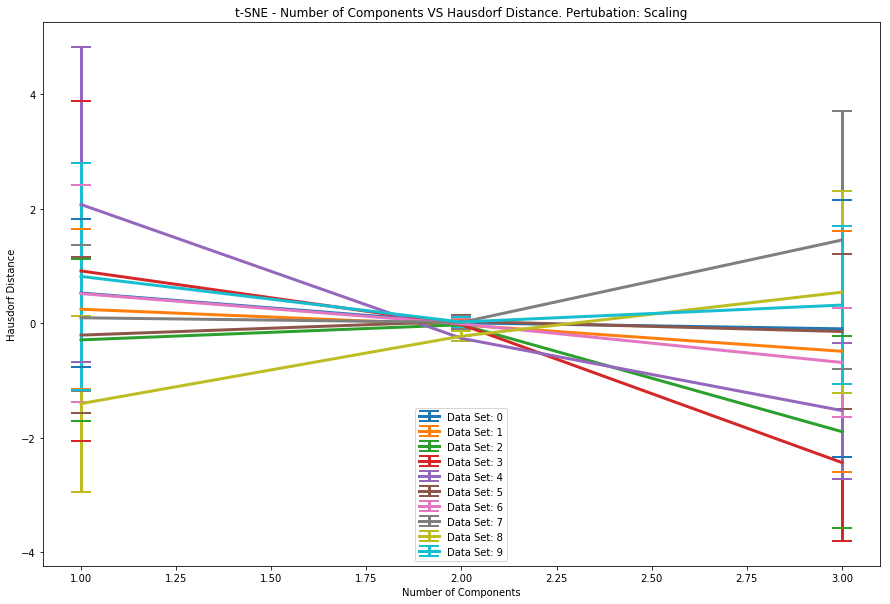

In [133]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(range(1,4), mean_hd_scaling_diff[:,i], yerr=std_hd_scaling_diff[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Number of Components VS Hausdorf Distance. Pertubation: Scaling")
plt.xlabel("Number of Components")
plt.ylabel("Hausdorf Distance")
plt.legend()

plt.show()

In [135]:
nr_datasets = 10
nr_pertubations = 10
nr_components = 2
perplexities = [5,20,30,50,100]
nr_perplexities = len(perplexities)

mean_hd_removal_diff_perplex = np.zeros([nr_perplexities, nr_datasets])
std_hd_removal_diff_perplex = np.zeros([nr_perplexities, nr_datasets])

mean_hd_scaling_diff_perplex = np.zeros([nr_perplexities, nr_datasets])
std_hd_scaling_diff_perplex = np.zeros([nr_perplexities, nr_datasets])


for iPerplex, perplexity in enumerate(perplexities):
    print("================================================================")
    print("                         Perplexity: {}                          ".format(perplexity))
    print("================================================================")

    nrComponents = 2
    
    for iDataset in range(nr_datasets):
        print("======================== Dataset {} of {} ========================".format(iDataset+1, nr_datasets))
        data = generate_dataset(iDataset)
        
        
        no_pertubation_data = np.zeros([nr_pertubations, data.shape[0], data.shape[1]])
        for iNoPert in range(nr_pertubations):
            print("No pertubation tsne {} of {}".format(iNoPert+1,nr_pertubations))
            no_pertubation_data[iNoPert,:,:] = tsne(data, nrComponents, perplexity)
            
        # Pairwise comparison
        no_pert = [hd(x,y) for i,x in enumerate(no_pertubation_data) \
                    for j,y in enumerate(no_pertubation_data) if i != j]
        
        # Random data point removal pertubation
        removal_pertubation_data = np.zeros([nr_pertubations, data.shape[0]-1, data.shape[1]])
        for j in range(nr_pertubations):
            print("Removal pertubation {} of {}".format(j+1,nr_pertubations))
            data_removal = np.delete(data,random.randint(1, len(data)-1),axis=0)
            removal_pertubation_data[j,:,:] = tsne(data_removal, nrComponents, perplexity)
            
        removal_pertubed = [hd(x,y) for i,x in enumerate(removal_pertubation_data) \
                    for j,y in enumerate(removal_pertubation_data) if i != j]
        

        
        mean_hd_removal_diff_perplex[iPerplex,iDataset] = np.mean(removal_pertubed - np.mean(no_pert))
        std_hd_removal_diff_perplex[iPerplex,iDataset] = np.std(removal_pertubed-np.mean(no_pert))
        
       

                         Perplexity: 5                          
======================== Dataset 1 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
======================== Dataset 2 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation ts

No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
======================== Dataset 4 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
======================== Dataset 5

No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
======================== Dataset 7 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal

Removal pertubation 10 of 10
======================== Dataset 9 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 of 10
Removal pertubation 1 of 10
Removal pertubation 2 of 10
Removal pertubation 3 of 10
Removal pertubation 4 of 10
Removal pertubation 5 of 10
Removal pertubation 6 of 10
Removal pertubation 7 of 10
Removal pertubation 8 of 10
Removal pertubation 9 of 10
Removal pertubation 10 of 10
======================== Dataset 10 of 10 ========================
No pertubation tsne 1 of 10
No pertubation tsne 2 of 10
No pertubation tsne 3 of 10
No pertubation tsne 4 of 10
No pertubation tsne 5 of 10
No pertubation tsne 6 of 10
No pertubation tsne 7 of 10
No pertubation tsne 8 of 10
No pertubation tsne 9 of 10
No pertubation tsne 10 o

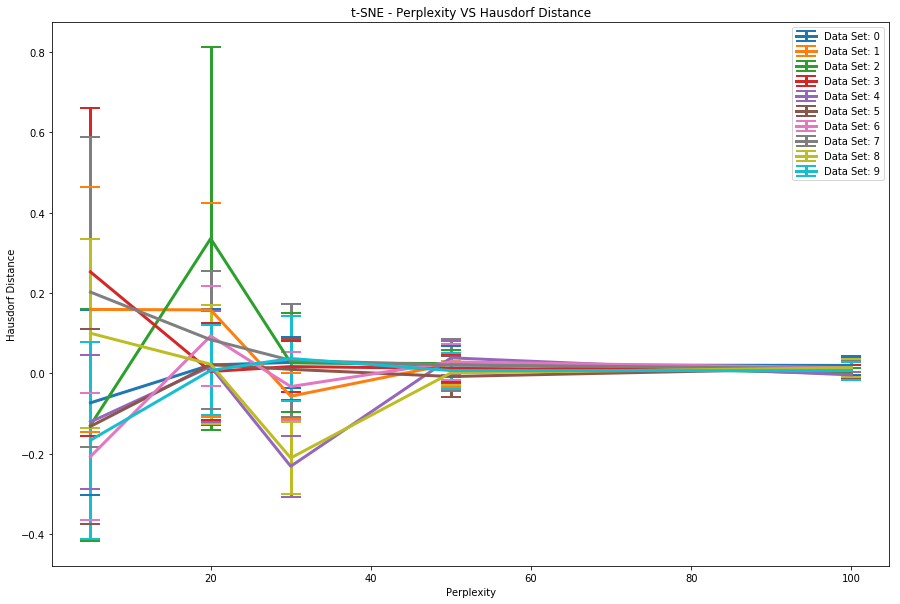

In [136]:
plt.figure(figsize=(15, 10))
for i in range(nr_datasets):
    plt.errorbar(perplexities, mean_hd_removal_diff_perplex[:,i], yerr=std_hd_removal_diff_perplex[:,i],
                capthick=2, capsize=10, linewidth=3, label="Data Set: {}".format(i))  

    
plt.title("t-SNE - Perplexity VS Hausdorf Distance")
plt.xlabel("Perplexity")
plt.ylabel("Hausdorf Distance")
plt.legend()

plt.show()